<a href="https://colab.research.google.com/github/Anant-gif/onlinefraud/blob/main/online_fraud.iipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.1 Imports

In [ ]:
import joblib
import warnings
import inflection
import numpy             as np
import pandas            as pd
import seaborn           as sns
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt

from scipy   import stats

from xgboost  import XGBClassifier

from sklearn.svm          import SVC
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score ,  roc_auc_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

## 0.2 Helper Functions

In [ ]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.0 Data Description

## 1.1 Loading Data

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/fraud_0.1origbase.csv')

In [ ]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [ ]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [ ]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [ ]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## 1.4 Data Types and Structure

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA

In [ ]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

# 2.0 Exploratory Data Analisys

In [ ]:
df2 = df1.copy()

Highly imbalanced dataset

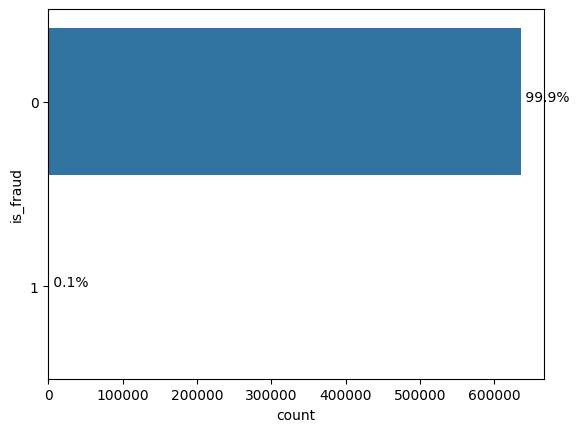

In [ ]:
ax = sns.countplot(y='is_fraud', data=df2);
total = df2['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

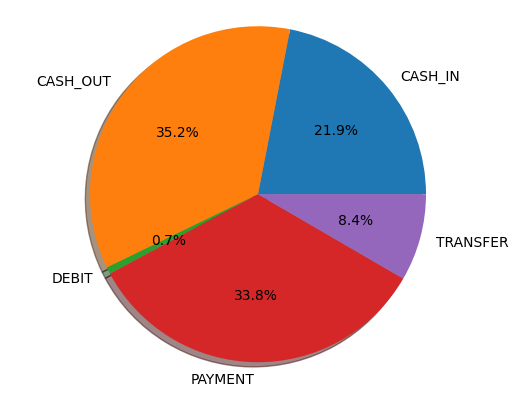

In [ ]:
labels = df2['type'].astype('category').cat.categories.tolist()
counts = df2['type'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

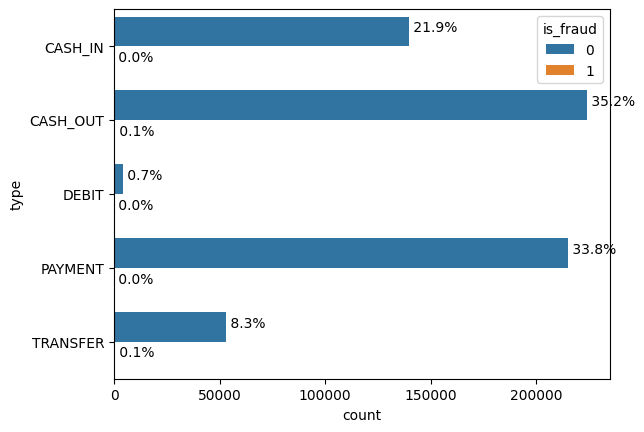

In [ ]:

ax = sns.countplot(y='type', hue='is_fraud', data=df3)

total = df2['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))



Fraud Transactions in CASH_OUT and TRANSFER only

In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df2.loc[df2.is_fraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT'
                                                             # & 'TRANSFER'

dfFraudTransfer = df2.loc[(df2.is_fraud == 1) & (df2.type == 'TRANSFER')]
dfFraudCashout = df2.loc[(df2.is_fraud == 1) & (df2.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout)))


 The types of fraudulent transactions are ['CASH_OUT', 'TRANSFER']

 The number of fraudulent TRANSFERs = 414

 The number of fraudulent CASH_OUTs = 407




The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions

In [ ]:
X_fraud = df2.loc[df2.is_fraud == 1]
Xnon_fraud = df2.loc[df2.is_fraud == 0]
print('\nThe fraction of fraudulent transactions with \'oldbalance_dest\' = \
\'newbalance_dest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(X_fraud.loc[(X_fraud.oldbalance_dest == 0) & \
(X_fraud.newbalance_dest == 0) & (X_fraud.amount)]) / (1.0 * len(X_fraud))))



The fraction of fraudulent transactions with 'oldbalance_dest' = 'newbalance_dest' = 0 although the transacted 'amount' is non-zero is: 0.5030450669914738


# 3.0 Feature Engineering

In [ ]:
df3 = df2.copy()

In [ ]:
# step
df3['step_days'] = df3['step'].apply(lambda i: i/24)
df3['step_weeks'] = df3['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df3['diff_new_old_balance'] = df3['newbalance_orig'] - df3['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df3['diff_new_old_destiny'] = df3['newbalance_dest'] - df3['oldbalance_dest']

# name orig and name dest
df3['name_orig'] = df3['name_orig'].apply(lambda i: i[0])
df3['name_dest'] = df3['name_dest'].apply(lambda i: i[0])
df3

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,0,0,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,0,0,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,0,0,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,0,0,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,0,0,15.875000,2.267857,0.00,8858.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,C,0.00,0.00,C,328534.52,357295.62,0,0,14.625000,2.089286,0.00,28761.10
636258,184,CASH_OUT,167820.71,C,62265.00,0.00,C,106429.48,274250.18,0,0,7.666667,1.095238,-62265.00,167820.70
636259,35,PAYMENT,8898.12,C,30808.00,21909.88,M,0.00,0.00,0,0,1.458333,0.208333,-8898.12,0.00
636260,277,CASH_OUT,176147.90,C,83669.00,0.00,C,0.00,176147.90,0,0,11.541667,1.648810,-83669.00,176147.90


# 4.0 Data Preparation

In [ ]:
df4 = df3.copy()

## 4.1 Spliting into Train and Test

In [ ]:
y = df4['is_fraud']
X = df4.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest','step_weeks', 'step_days'], axis=1)

In [ ]:
# spliting into temp and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

## 4.2 One Hot Encoder

In [ ]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)
X_train.head()
X_test.head()

,step,type_PAYMENT,type_CASH_OUT,type_CASH_IN,type_TRANSFER,type_DEBIT,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
578630,94,0,0,0,1,0,672901.28,0.00,0.00,8881502.26,10664836.01,0.00,1783333.75
248692,234,0,1,0,0,0,42319.66,0.00,0.00,273167.66,315487.32,0.00,42319.66
43980,231,0,0,0,0,1,5635.52,133346.00,127710.48,45858.49,51494.02,-5635.52,5635.53
331603,358,0,0,1,0,0,156974.98,425464.73,582439.71,1033044.87,876069.89,156974.98,-156974.98
123136,33,0,0,1,0,0,321256.73,10501.00,331757.73,87655.83,0.00,321256.73,-87655.83


## 4.3 Rescaling

In [ ]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_train.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

X_params[num_columns] = mm.fit_transform(X_train[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 5.0 Feature Selection

In [ ]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

# 6.0 Machine Learning Modeling

In [ ]:
X_train_cs = X_train[final_columns_selected]

X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 6.1 Logistic Regression

In [ ]:
def ml_scores(model_name, y_true, y_pred,y_probs):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc= roc_auc_score(y_test,y_probs[:,1])

    return pd.DataFrame({'Balanced Accuracy':accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1': f1,
                         'auc': auc},
                        index=[model_name])


In [ ]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_test_cs)
y_probs = lg.predict_proba(X_test_cs)

In [ ]:

lg_results = ml_scores('Logistic Regression', y_test, y_pred,y_probs)
lg_results


,Balanced Accuracy,Precision,Recall,F1,auc
Logistic Regression,0.594512,1.0,0.189024,0.317949,0.914964


### 6.1.1 Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       1.00      0.19      0.32       164

    accuracy                           1.00    127253
   macro avg       1.00      0.59      0.66    127253
weighted avg       1.00      1.00      1.00    127253



## 6.2 K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_test_cs)
y_probs = knn.predict_proba(X_test_cs)

In [ ]:
knn_results = ml_scores('K Nearest Neighbors', y_test, y_pred,y_probs)
knn_results

,Balanced Accuracy,Precision,Recall,F1,auc
K Nearest Neighbors,0.628041,0.954545,0.256098,0.403846,0.76482


### 6.2.1 Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.95      0.26      0.40       164

    accuracy                           1.00    127253
   macro avg       0.98      0.63      0.70    127253
weighted avg       1.00      1.00      1.00    127253



## 6.3 Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_test_cs)
y_probs = rf.predict_proba(X_test_cs)


In [ ]:
rf_results = ml_scores('Random Forest', y_test, y_pred,y_probs)
rf_results

,Balanced Accuracy,Precision,Recall,F1,auc
Random Forest,0.884135,0.976744,0.768293,0.860068,0.983481


### 6.3.1 Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.98      0.77      0.86       164

    accuracy                           1.00    127253
   macro avg       0.99      0.88      0.93    127253
weighted avg       1.00      1.00      1.00    127253



## 6.4 XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_test_cs)
y_probs = xgb.predict_proba(X_test_cs)

In [ ]:
xgb_results = ml_scores('XGB', y_test, y_pred,y_probs)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,auc
XGB,0.905456,0.943262,0.810976,0.872131,0.999525


### 6.4.1 Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127089
           1       0.94      0.81      0.87       164

    accuracy                           1.00    127253
   macro avg       0.97      0.91      0.94    127253
weighted avg       1.00      1.00      1.00    127253



### 6.5  Performance

In [ ]:
modeling_performance = pd.concat([lg_results, knn_results,rf_results, xgb_results,])
modeling_performance.sort_values(by="auc", ascending=False)

,Balanced Accuracy,Precision,Recall,F1,auc
XGB,0.905456,0.943262,0.810976,0.872131,0.999525
Random Forest,0.884135,0.976744,0.768293,0.860068,0.983481
Logistic Regression,0.594512,1.000000,0.189024,0.317949,0.914964
K Nearest Neighbors,0.628041,0.954545,0.256098,0.403846,0.764820


# 7.0 Hyperparameter Fine Tuning

In [ ]:
auc = make_scorer(roc_auc_score)

In [ ]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

## 8 Results

In [ ]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [ ]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
y_pred = xgb_gs.predict(X_train_cs)
probs = xgb_gs.predict_proba(X_train_cs)
print(roc_auc_score(y_train, probs[:,1]))

0.999995607616942


# 9.0 Conclusions

## 9.1 Final Model

In [ ]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_train)



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
joblib.dump(final_model, 'model_cycle1.joblib')

['model_cycle1.joblib']

# 10 Validating Results

# 10.1 Undersampling


In [ ]:
df10 = df4.copy()
df10

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,0,0,11.791667,1.684524,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,0,0,5.500000,0.785714,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,0,0,14.791667,2.113095,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,0,0,5.625000,0.803571,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,0,0,15.875000,2.267857,0.00,8858.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,C,0.00,0.00,C,328534.52,357295.62,0,0,14.625000,2.089286,0.00,28761.10
636258,184,CASH_OUT,167820.71,C,62265.00,0.00,C,106429.48,274250.18,0,0,7.666667,1.095238,-62265.00,167820.70
636259,35,PAYMENT,8898.12,C,30808.00,21909.88,M,0.00,0.00,0,0,1.458333,0.208333,-8898.12,0.00
636260,277,CASH_OUT,176147.90,C,83669.00,0.00,C,0.00,176147.90,0,0,11.541667,1.648810,-83669.00,176147.90


In [ ]:


Fraudulent_Transaction = df10[df10.is_fraud ==1]
Not_Fraudulent_Transaction = df10[df10.is_fraud ==0]

In [ ]:
print('Fraudulent Transaction: {}'.format(len(Fraudulent_Transaction)))
print('Not Fraudulent Transaction: {}'.format(len(Not_Fraudulent_Transaction)))


Fraudulent Transaction: 821
Not Fraudulent Transaction: 635441


Building a sample dataset containing similar distribution of Non Fraudulent transactions and Fraudulent transactions. This rectifies the class-imbalance and helps our machine learning model to perform better predictions.

Since we want to build a model that detects Fraud, we base our sampling on the number of transactions classed as fraudulent in our original dataset.

Fraudulent transactions: 8213

In [ ]:
Non_Fraudulent_Sample = Not_Fraudulent_Transaction.sample(n=8213)

In [ ]:
df10= pd.concat([Non_Fraudulent_Sample, Fraudulent_Transaction], axis=0)

In [ ]:
df10.describe()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,diff_new_old_balance,diff_new_old_destiny
count,9034.000000,9.034000e+03,9.034000e+03,9.034000e+03,9.034000e+03,9.034000e+03,9034.000000,9034.000000,9034.000000,9034.000000,9.034000e+03,9.034000e+03
mean,254.158291,2.952740e+05,8.856966e+05,7.781284e+05,1.050647e+06,1.226529e+06,0.090879,0.000221,10.589929,1.512847,-1.075682e+05,1.758823e+05
std,154.137225,1.029081e+06,2.892204e+06,2.786457e+06,3.330859e+06,3.657424e+06,0.287453,0.014878,6.422384,0.917483,8.409452e+05,9.033622e+05
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.041667,0.005952,-1.000000e+07,-2.172566e+06
25%,155.000000,1.554872e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,6.458333,0.922619,-1.626171e+04,0.000000e+00
50%,252.000000,9.007549e+04,2.010300e+04,0.000000e+00,7.734059e+04,1.864069e+05,0.000000,0.000000,10.500000,1.500000,-4.695500e+01,0.000000e+00
75%,351.000000,2.354676e+05,1.798264e+05,1.106282e+05,8.881773e+05,1.122655e+06,0.000000,0.000000,14.625000,2.089286,0.000000e+00,1.551661e+05
max,742.000000,3.239349e+07,3.767004e+07,3.439305e+07,1.390260e+08,1.426189e+08,1.000000,1.000000,30.916667,4.416667,7.847283e+05,3.239349e+07


### 10.1.1 Data Preprocessing

In [ ]:
y = df10['is_fraud']
X = df10.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)

Train Test Split, one hot encoder and Rescaling

In [ ]:
# spliting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_train.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

X_params[num_columns] = mm.fit_transform(X_train[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [ ]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

In [ ]:
X_train_cs = X_train[final_columns_selected]

X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 10.1.2 Loading the model

In [ ]:
model = joblib.load('models/model_cycle1.joblib')

In [ ]:
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_test_cs)
y_probs = xgb.predict_proba(X_test_cs)

Results

In [ ]:
xgb_results = ml_scores('XGB', y_test, y_pred,y_probs)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,auc
XGB,0.953051,0.973856,0.908537,0.940063,0.991045
